# [IAPR 2020:][iapr2020] Lab 2 ‒  Object description

**Authors:** first_name_1 last_name_1, first_name_2 last_name_2, first_name_3 last_name_3  
**Due date:** 24.04.2020

[iapr2020]: https://github.com/LTS5/iapr-2020

## Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [28]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1
In the `lab-02-data/part1` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try first the Fourier Descriptors.
You can make several attempts: e.g. with and without invariance to rotation, translation, scaling, etc.
You can also for instance rotate the images and assess the invariance in rotation.

**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point.
Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

Then feel free to try other features, the more you try, the better it will be (for you).

### 1.1 Data visualization

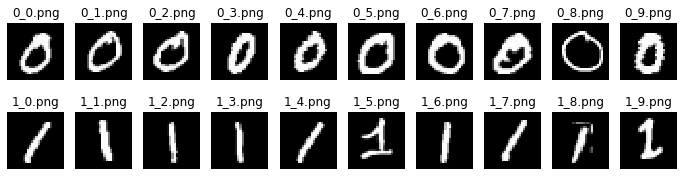

In [29]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load images
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
#  Load twos
zeros_path = os.path.join(data_base_path, data_folder, 'part1', '0')
zeros_names = [nm for nm in os.listdir(zeros_path) if '.png' in nm]  # make sure to only load .png
zeros_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(zeros_path, nm) for nm in zeros_names])
zeros_im = skimage.io.concatenate_images(ic)
#  Load ones
ones_path = os.path.join(data_base_path, data_folder, 'part1', '1')
ones_names = [nm for nm in os.listdir(ones_path) if '.png' in nm]  # make sure to only load .png
ones_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(ones_path, nm) for nm in ones_names]))
ones_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 1.2 Fourier descriptors
Add your implementation and discussion



#### Pre-processing

In [30]:
from skimage.morphology import binary_erosion
from skimage.morphology import diameter_opening
import numpy as np
import cmath

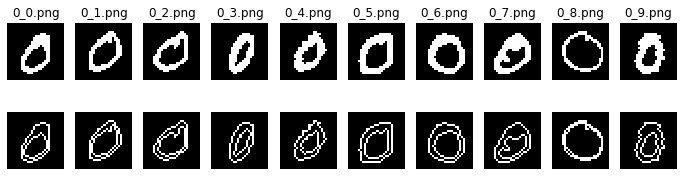

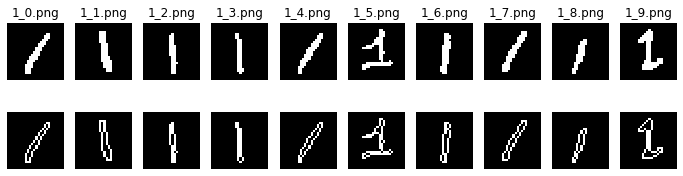

In [31]:
zero_morphologies = []
one_morphologies = []
zero_contours = []
one_contours = []

def make_morphology(image):
    booleans_list = image > 128
    binary = np.array([[1 if boolean else 0 for boolean in booleans] for booleans in booleans_list])
    return skimage.morphology.diameter_opening(binary,5)

# Compute contours
for image in zeros_im:
    morphology = make_morphology(image)
    zero_morphologies.append(morphology)
    zero_contours.append( skimage.morphology.binary_erosion(morphology) ^ morphology )

for image in ones_im:
    morphology = make_morphology(image)
    one_morphologies.append(morphology)
    one_contours.append( skimage.morphology.binary_erosion(morphology) ^ morphology )
    
    
# Plot
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, img, name, ax2, img2 in zip(axes[0], zero_morphologies, zeros_names, axes[1], zero_contours):
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(name)
    ax2.imshow(img2, cmap='gray')
    ax2.axis('off')
    
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))    
for ax, img, name, ax2, img2 in zip(axes[0], one_morphologies, ones_names, axes[1], one_contours):
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(name)
    ax2.imshow(img2, cmap='gray')
    ax2.axis('off')

#### Outside contour with successive points


In [32]:
def get_outside_contours(images):
    # Getting outside contour starting with top middle point and going in
    # counter-clockwise order.
    
    neighbors = [(0,-1),(1,-1),(1,0),(1,1),(0,1),(-1,1),(-1,0),(-1,-1)]
    arrow = 0
    x,y = 0,0
    contours = []
    cursor = (0,0)
    
    for image in np.array(images):
        contour = []
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                if image[i,j]: 

                    last_pix = (i,j)
                    arrow = 0
                    contour.append((i,j))
                    break
            if len(contour): break

        if len(contour):
            while contour[0] != contour[-1] or len(contour)==1 :
                for i in range(8):
                    direction = neighbors[ (arrow+i)%8 ]
                    new_pix = (contour[-1][0]+direction[0],contour[-1][1]+direction[1])

                    if image[new_pix[0],new_pix[1]]:
                        contour.append((new_pix))
                        arrow = (arrow+i - 2)%8
                        break
        contours.append(contour)
    return contours
        

Here we use shades of gray to show how the points are ordered.

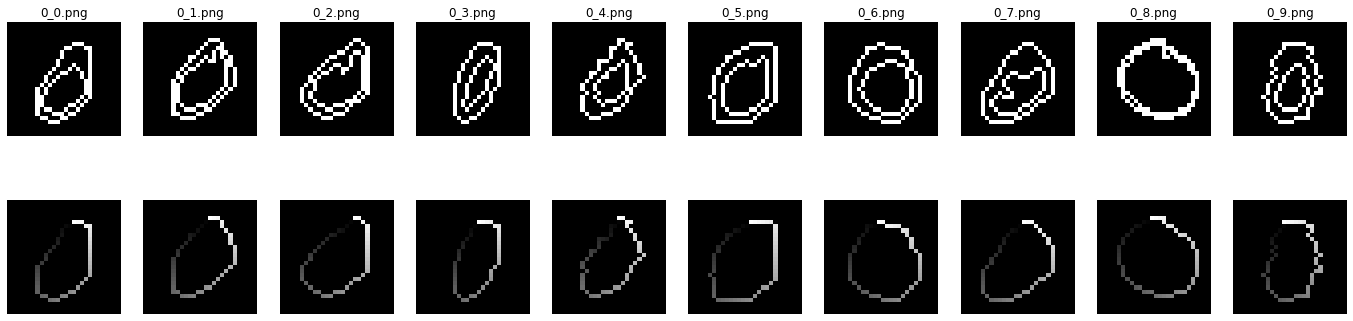

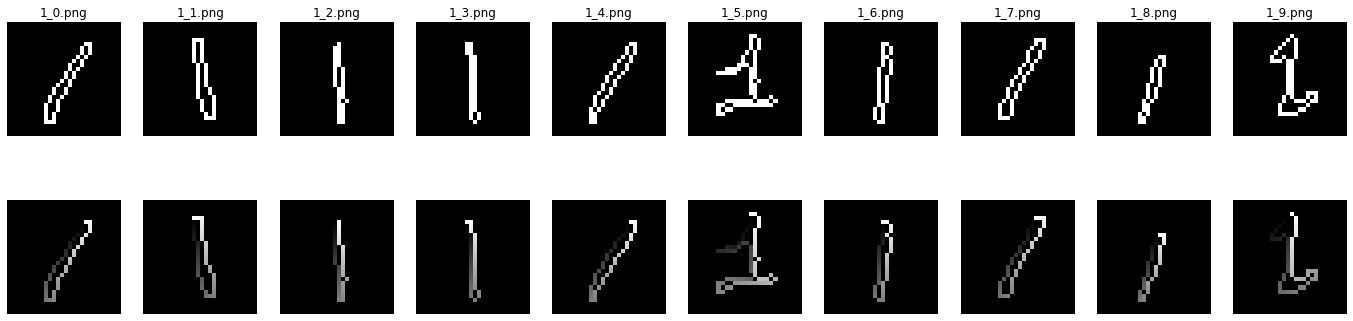

In [33]:
zero_outside_contours = get_outside_contours(zero_contours)
one_outside_contours = get_outside_contours(one_contours)
canvases_zeros = []
canvases_ones = []

for contour in zero_outside_contours:
    canvas = np.zeros_like(zero_contours[0])
    for i in range(len(contour)):
        canvas[contour[i]]= i
    canvases_zeros.append(canvas)
    
for contour in one_outside_contours:
    canvas = np.zeros_like(one_contours[0])
    for i in range(len(contour)):
        canvas[contour[i]]= i
    canvases_ones.append(canvas)
    
fig, axes = plt.subplots(2, len(zeros_im), figsize=(24, 6))
for ax, img, name, ax2, img2 in zip(axes[0], zero_contours, zeros_names, axes[1], canvases_zeros):
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(name)
    ax2.imshow(img2, cmap='gray')
    ax2.axis('off')
    
fig, axes = plt.subplots(2, len(ones_im), figsize=(24, 6))
for ax, img, name, ax2, img2 in zip(axes[0], one_contours, ones_names, axes[1], canvases_ones):
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(name)
    ax2.imshow(img2, cmap='gray')
    ax2.axis('off')

#### Fourier Description

In [34]:
def fourier_description(contours, coeffs):
    L = len(coeffs)
    conts = len(contours)
    descriptors = np.zeros((L,conts), dtype=complex)
    
    for l in range(L):
        for c in range(conts):
            for k in range(len(contours[c])):
                descriptors[l,c] += complex(contours[c][k][0],contours[c][k][1])*cmath.exp(-1j*2.0*cmath.pi*k*coeffs[l]/len(contours[c]) )
                
            descriptors[l,c] = abs(descriptors[l,c])
    
    return descriptors    

/Users/MaximKryukov/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/MaximKryukov/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


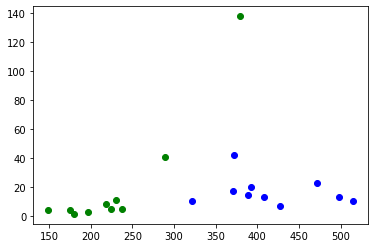

In [35]:
descriptors_zero = fourier_description(zero_outside_contours, [1,2])
descriptors_one= fourier_description(one_outside_contours, [1,2])

plt.plot(descriptors_zero[0],descriptors_zero[1], 'bo')
plt.plot(descriptors_one[0],descriptors_one[1], 'go')

plt.show()

Adding scaling invariance:

/Users/MaximKryukov/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/MaximKryukov/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


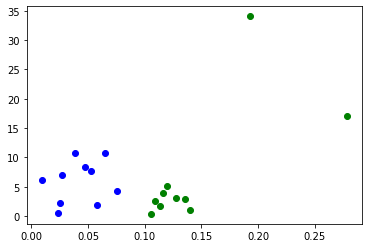

In [36]:
descriptors_zero = fourier_description(zero_outside_contours, [3,4,1])
descriptors_one= fourier_description(one_outside_contours, [3,4,1])

scaled_descriptors_zero = np.divide(descriptors_zero[0:2],descriptors_zero[2])
scaled_descriptors_one = np.divide(descriptors_one[0:2],descriptors_one[2])
    
plt.plot(scaled_descriptors_zero[0],descriptors_zero[1], 'bo')
plt.plot(scaled_descriptors_one[0],descriptors_one[1], 'go')

plt.show()

### 1.3 Additional method(s)

## TODO:

- Axis of inertia
- Area
- Perimeter 
- Compacity

(-0.5, 27.5)


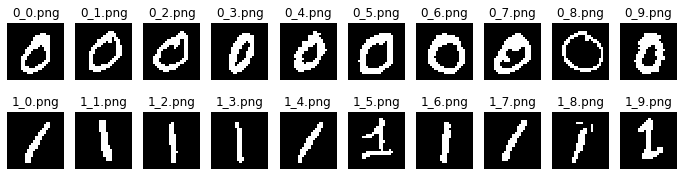

In [50]:
zero_regions = [zero_region > 128 for zero_region in zeros_im]
one_regions = [one_region > 128 for one_region in ones_im]

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zero_regions, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], one_regions, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
print(ax.get_xlim())

In [246]:
from numpy.linalg import eig

zero_areas, one_areas = [zero_region.sum().sum() for zero_region in zero_regions], \
    [one_region.sum().sum() for one_region in one_regions]

zero_perimeters, one_perimeters  = [zero_contour.sum().sum() for zero_contour in zero_contours], \
    [one_contour.sum().sum() for one_contour in one_contours]

zero_compacities, one_compacities = [P*P/A for P, A in zip(zero_perimeters, zero_areas)], \
    [P*P/A for P, A in zip(one_perimeters, one_areas)]

zero_region_coords, one_region_coords = [(24 - np.where(zero_region)[1], 24 - np.where(zero_region)[0]) for zero_region in zero_regions], \
    [(24 - np.where(one_region)[1], 24 - np.where(one_region)[0]) for one_region in one_regions]

zero_covs, one_covs = [np.cov(zero_coords) for zero_coords in zero_region_coords], \
    [np.cov(one_coords) for one_coords in one_region_coords]

zero_eigs, one_eigs = [eig(zero_cov) for zero_cov in zero_covs], [eig(one_cov) for one_cov in one_covs]

primary_axis_vector = [1, 0]

zero_angles, one_angles = [np.arccos(np.sum(zero_eig[1][0] * primary_axis_vector)) for zero_eig in zero_eigs], \
    [np.arccos(np.sum(one_eig[1][0] * primary_axis_vector)) for one_eig in one_eigs]

In [247]:
zero_compacities

[43.75757575757576,
 58.266129032258064,
 56.909774436090224,
 35.25179856115108,
 37.75167785234899,
 49.49707602339181,
 45.82248520710059,
 40.86187845303867,
 91.24752475247524,
 35.71686746987952]

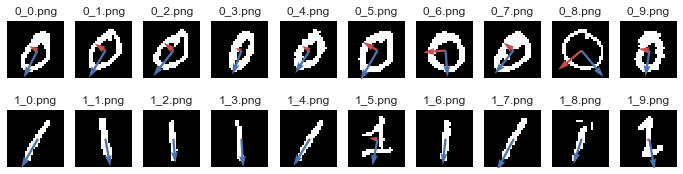

In [164]:
# Plot images

origin = [14, 14]
scale = 70
width = 0.04

fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm, zero_eig in zip(axes[0], zero_regions, zeros_names, zero_eigs):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    ax.plot(14, 14, 'r')
    zero_vecs = np.multiply(zero_eig[1], zero_eig[0][:, np.newaxis])
    ax.quiver(*origin, *zero_vecs[0], color='r', scale=scale, width=width)
    ax.quiver(*origin, *zero_vecs[1], color='b', scale=scale, width=width)
for ax, im, nm, one_eig in zip(axes[1], one_regions, ones_names, one_eigs):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    one_vecs = np.multiply(one_eig[1], one_eig[0][:, np.newaxis])
    ax.quiver(*origin, *one_vecs[0], color='r', scale=scale, width=width)
    ax.quiver(*origin, *one_vecs[1], color='b', scale=scale, width=width)

In [232]:
def get_moments(image, i, j):
    
    M_i_j = 0
    for k in range(image.shape[0]):
        for l in range(image.shape[1]):
            M_i_j += k**i * l**j * image[k, l]
            
    return M_i_j
            
def get_invariant_moments(image, i, j, with_scaled=True):
    k_mean = get_moments(image, 1, 0)/get_moments(image, 0, 0)
    l_mean = get_moments(image, 0, 1)/get_moments(image, 0, 0)
    mu_0_0 = get_moments(image, 0, 0)
    
    mu_i_j = 0
    for k in range(image.shape[0]):
        for l in range(image.shape[1]):
            mu_i_j += (k - k_mean)**i * (l - l_mean)**j * image[k, l]
    
    # Applying scaling
    eta_i_j = mu_i_j/mu_0_0**((i+j)/2 + 1)
    
    if with_scaled:
        return mu_i_j, eta_i_j
    else:
        return mu_i_j
    
def get_first_4_HU_moments(image, num_until=2, with_scaled=True):
    if with_scaled:
        _, val_0_2 = get_invariant_moments(image, 0, 2)
        _, val_2_0 = get_invariant_moments(image, 2, 0)
        _, val_1_1 = get_invariant_moments(image, 1, 1)
        _, val_1_2 = get_invariant_moments(image, 1, 2)
        _, val_2_1 = get_invariant_moments(image, 2, 1)
        _, val_3_0 = get_invariant_moments(image, 3, 0)
        _, val_0_3 = get_invariant_moments(image, 0, 3)
    else:
        val_0_2 = get_invariant_moments(image, 0, 2, with_scaled=False)
        val_2_0 = get_invariant_moments(image, 2, 0, with_scaled=False)
        val_1_1 = get_invariant_moments(image, 1, 1, with_scaled=False)
        val_1_2 = get_invariant_moments(image, 1, 2, with_scaled=False)
        val_2_1 = get_invariant_moments(image, 2, 1, with_scaled=False)
        val_3_0 = get_invariant_moments(image, 3, 0, with_scaled=False)
        val_0_3 = get_invariant_moments(image, 0, 3, with_scaled=False)
    
    I_1 = val_2_0 + val_0_2
    I_2 = (val_2_0 - val_0_2)**2 + 4*val_1_1**2
    I_3 = (val_3_0 - 3*val_1_2)**2 + (3*val_2_1 - val_0_3)**2
    I_4 = (val_3_0 + val_1_2)**2 + (val_2_1 + val_0_3)**2
    
    return [I_2, I_2, I_3, I_4]

Perimeter, area and compacity

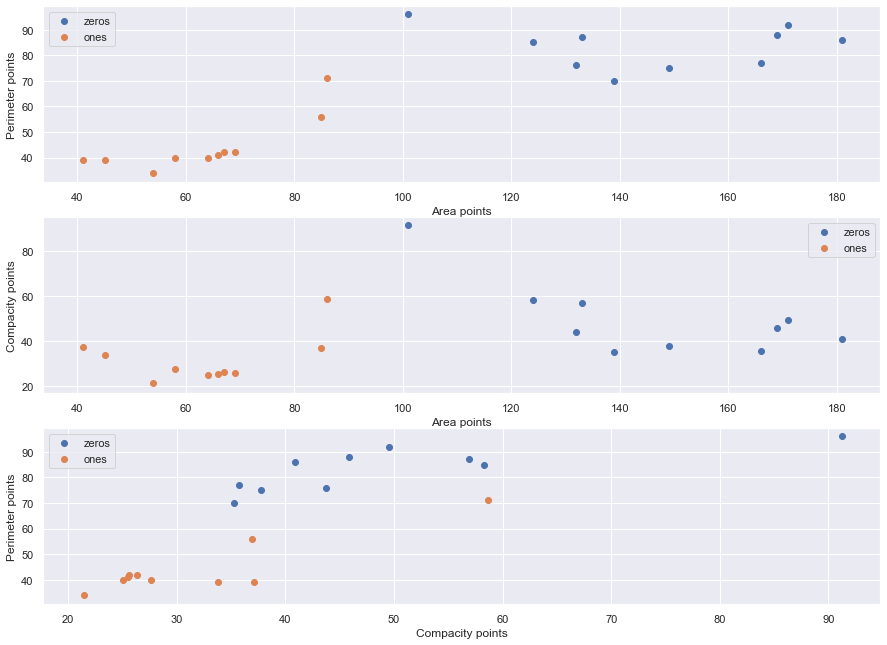

In [250]:
f, ax = plt.subplots(3, 1, figsize=(15, 11))

ax[0].scatter(zero_areas, zero_perimeters, label='zeros')
ax[0].scatter(one_areas, one_perimeters, label='ones')
ax[0].set_xlabel('Area points')
ax[0].set_ylabel('Perimeter points')
ax[0].legend()

ax[1].scatter(zero_areas, zero_compacities, label='zeros')
ax[1].scatter(one_areas, one_compacities, label='ones')
ax[1].set_xlabel('Area points')
ax[1].set_ylabel('Compacity points')
ax[1].legend()

ax[2].scatter(zero_compacities, zero_perimeters, label='zeros')
ax[2].scatter(one_compacities, one_perimeters, label='ones')
ax[2].set_xlabel('Compacity points')
ax[2].set_ylabel('Perimeter points')
ax[2].legend()

In [236]:
zeros_reshaped = zeros_im.reshape(len(zeros_im), -1)
ones_reshaped = ones_im.reshape(len(ones_im), -1)
data = np.concatenate((zeros_reshaped, ones_reshaped), axis = 0) 
labels = [0]*len(zeros_im) + [1]*len(ones_im)
standardized_data = StandardScaler().fit_transform(data)
covar_matrix = np.matmul(standardized_data.T , standardized_data)
values, vectors = eigh(covar_matrix, eigvals=(782,783))
projection_coord = np.matmul(vectors.T, standardized_data.T)
to_plot = pd.DataFrame(data= {'x' : projection_coord[0], 'y' : projection_coord[1], 'label':labels})

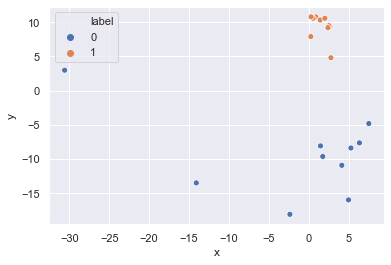

In [237]:
sns.scatterplot(x = to_plot.x, y = to_plot.y, hue=to_plot.label)

In [238]:
to_plot

,x,y,label
0,5.266307,-8.374688,0
1,1.457238,-8.070558,0
2,1.740011,-9.621134,0
3,7.507196,-4.804009,0
4,6.330977,-7.628324,0
5,-2.375670,-18.069416,0
6,-14.094087,-13.479693,0
7,4.963695,-15.963155,0
8,-30.581274,2.995598,0
9,4.125605,-10.907852,0


In [239]:
from sklearn import decomposition
pca = decomposition.PCA()
pca.n_components = 2
pca_data = pca.fit_transform(standardized_data)
pca_data = pca_data.T

In [48]:
to_plot = pd.DataFrame(data= {'x' : pca_data[0], 'y' : pca_data[1], 'label':labels})

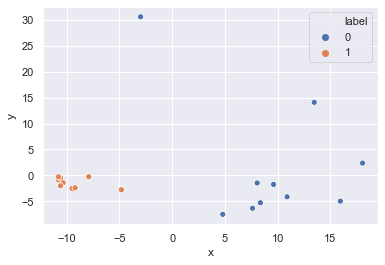

In [49]:
sns.scatterplot(x = to_plot.x, y = to_plot.y, hue=to_plot.label)

#### TSNE

In [50]:
from sklearn.manifold import TSNE


model = TSNE(n_components=2, random_state=0, perplexity=2)


tsne_data = model.fit_transform(standardized_data)
tsne_data = tsne_data.T
to_plot = pd.DataFrame(data= {'x' : tsne_data[0], 'y' : tsne_data[1], 'label':labels})

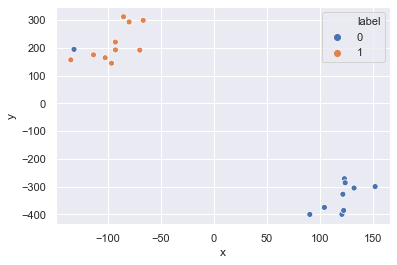

In [51]:
sns.scatterplot(x = to_plot.x, y = to_plot.y, hue=to_plot.label)

In [52]:
def rotate_image(img):
    rotated_image = [[] for x in range(len(img))]
    for i in range(len(img)):
        for j in range(len(img[i])):
            rotated_image[len(img) - j - 1].append(img[i][j])
    return rotated_image

In [53]:
model.predict(x_train)

AttributeError: 'TSNE' object has no attribute 'predict'

In [ ]:
[np.array([0.,1.])]*2

## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 2.1 Data visualization

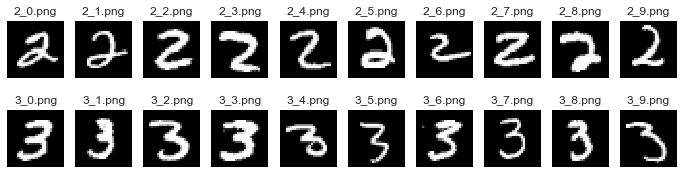

In [58]:
#  Load zeros
twos_path = os.path.join(data_base_path, data_folder, 'part2', '2')
twos_names = [nm for nm in os.listdir(twos_path) if '.png' in nm]  # make sure to only load .png
twos_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(twos_path, nm) for nm in twos_names])
twos_im = skimage.io.concatenate_images(ic)
#  Load ones
threes_path = os.path.join(data_base_path, data_folder, 'part2', '3')
threes_names = [nm for nm in os.listdir(threes_path) if '.png' in nm]  # make sure to only load .png
threes_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(threes_path, nm) for nm in threes_names]))
threes_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 2.2 Additional method(s) and conclusion
Add your implementations and discussions here

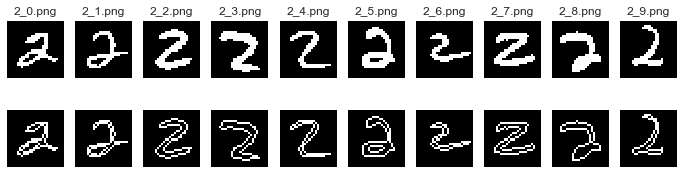

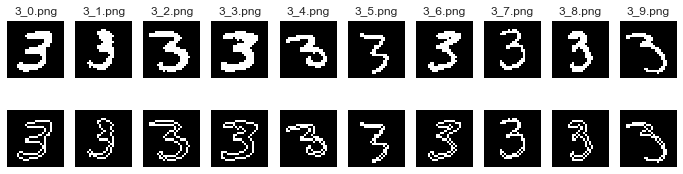

In [60]:
two_morphologies = []
three_morphologies = []
two_contours = []
three_contours = []

# Compute contours
for image in twos_im:
    morphology = make_morphology(image)
    two_morphologies.append(morphology)
    two_contours.append( skimage.morphology.binary_erosion(morphology) ^ morphology )

for image in threes_im:
    morphology = make_morphology(image)
    three_morphologies.append(morphology)
    three_contours.append( skimage.morphology.binary_erosion(morphology) ^ morphology )
    
    
# Plot
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, img, name, ax2, img2 in zip(axes[0], two_morphologies, twos_names, axes[1], two_contours):
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(name)
    ax2.imshow(img2, cmap='gray')
    ax2.axis('off')
    
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))    
for ax, img, name, ax2, img2 in zip(axes[0], three_morphologies, threes_names, axes[1], three_contours):
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(name)
    ax2.imshow(img2, cmap='gray')
    ax2.axis('off')

#### Outside contour with successive points


Here we use shades of gray to show how the points are ordered.

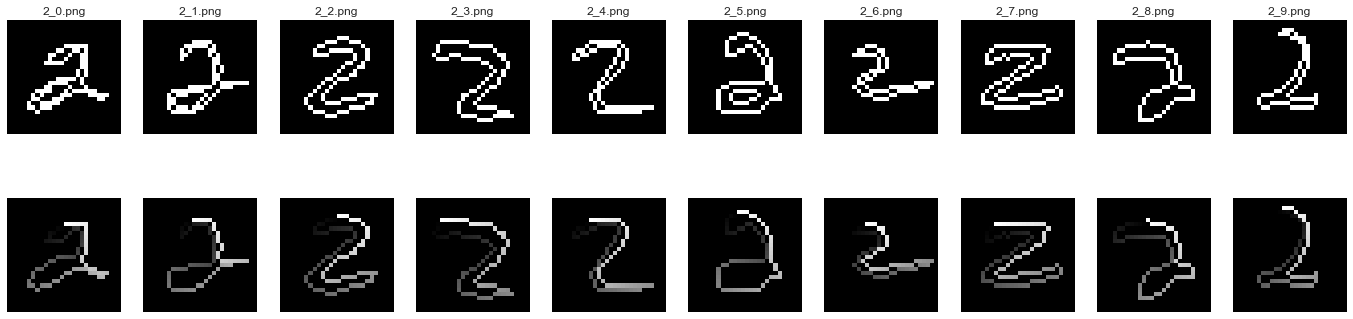

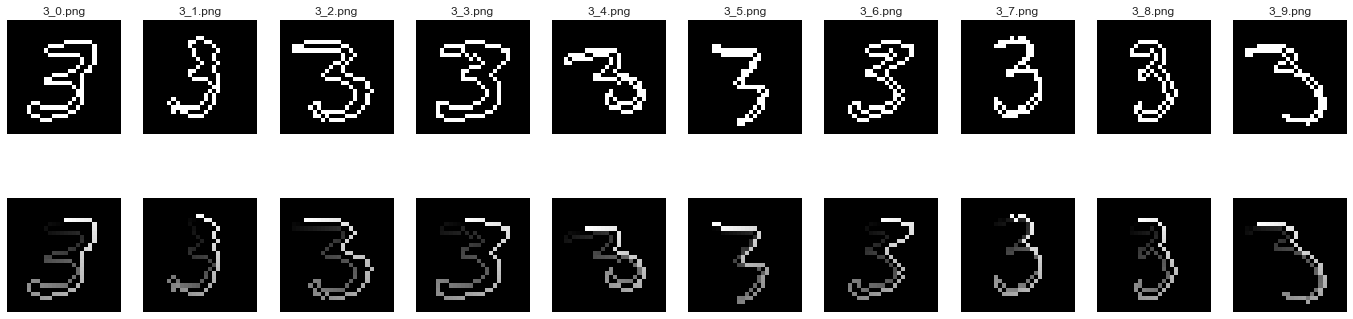

In [66]:
two_outside_contours = get_outside_contours(two_contours)
three_outside_contours = get_outside_contours(three_contours)
canvases_twos = []
canvases_threes = []

for contour in two_outside_contours:
    canvas = np.zeros_like(two_contours[0])
    for i in range(len(contour)):
        canvas[contour[i]]= i
    canvases_twos.append(canvas)
    
for contour in three_outside_contours:
    canvas = np.zeros_like(three_contours[0])
    for i in range(len(contour)):
        canvas[contour[i]]= i
    canvases_threes.append(canvas)
    
fig, axes = plt.subplots(2, len(twos_im), figsize=(24, 6))
for ax, img, name, ax2, img2 in zip(axes[0], two_contours, twos_names, axes[1], canvases_twos):
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(name)
    ax2.imshow(img2, cmap='gray')
    ax2.axis('off')
    
fig, axes = plt.subplots(2, len(threes_im), figsize=(24, 6))
for ax, img, name, ax2, img2 in zip(axes[0], three_contours, threes_names, axes[1], canvases_threes):
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(name)
    ax2.imshow(img2, cmap='gray')
    ax2.axis('off')

#### Fourier Description

/Users/MaximKryukov/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/MaximKryukov/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


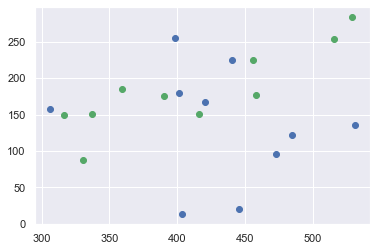

In [67]:
descriptors_two = fourier_description(two_outside_contours, [1,2])
descriptors_three= fourier_description(three_outside_contours, [1,2])

plt.plot(descriptors_two[0],descriptors_two[1], 'bo')
plt.plot(descriptors_three[0],descriptors_three[1], 'go')

plt.show()

Adding scaling invariance:

/Users/MaximKryukov/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/MaximKryukov/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


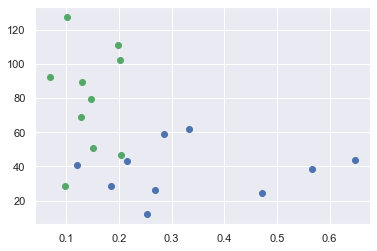

In [69]:
descriptors_two = fourier_description(two_outside_contours, [3,4,1])
descriptors_three = fourier_description(three_outside_contours, [3,4,1])

scaled_descriptors_two = np.divide(descriptors_two[0:2],descriptors_two[2])
scaled_descriptors_three = np.divide(descriptors_three[0:2],descriptors_three[2])
    
plt.plot(scaled_descriptors_two[0],descriptors_two[1], 'bo')
plt.plot(scaled_descriptors_three[0],descriptors_three[1], 'go')

plt.show()